In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat, add_trend
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.adfvalues import mackinnonp, mackinnoncrit
from pandas.core.nanops import nanmean as pd_nanmean
import warnings
from sklearn.metrics import r2_score
warnings.filterwarnings('ignore')

#### 1. Проверить является ли ряд стационарным в широком смысле

Считываем данные

In [4]:
consumption = pd.read_excel('training.xlsx')

consumption.sort_values('Date', axis=0, inplace=True)
consumption['Date'] = pd.to_datetime(consumption.Date, format='%Y-%m-%d')
consumption.index = consumption.Date
consumption.drop('Date', axis=1, inplace=True)
consumption.head()

,Value
Date,
1959-01-01,22.8331
1959-02-01,23.2802
1959-03-01,23.6156
1959-04-01,24.1186
1959-05-01,24.4820


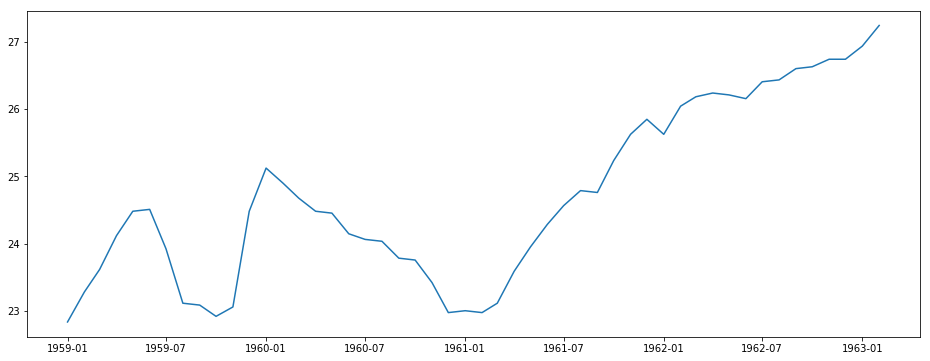

In [105]:
plt.figure(figsize=(16,6))
plt.plot(consumption.Value[:50])

i. Проведем визуальную оценку. Построим график на котором будет отображен сам ряд и различные скользящие 

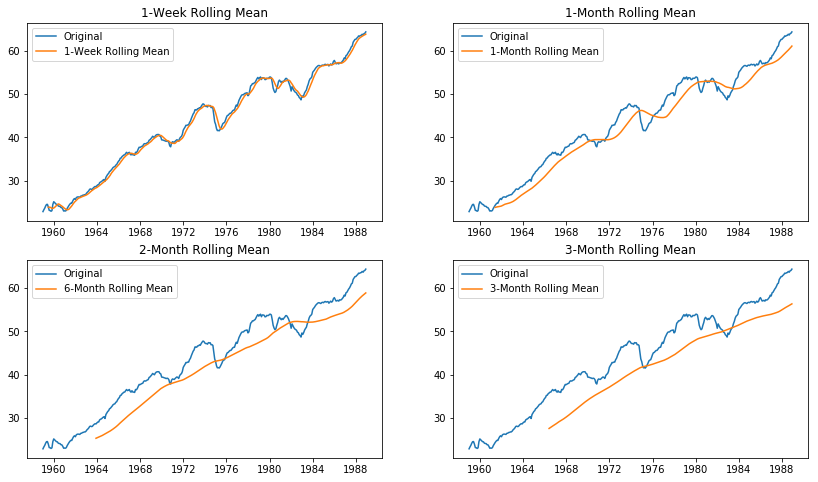

In [14]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)
window = 7
axes[0][0].plot(consumption.index, consumption, label='Original')
axes[0][0].plot(
    consumption.index,
    consumption.rolling(
        window=window).mean(),
    label='1-Week Rolling Mean')
axes[0][0].set_title("1-Week Rolling Mean")
axes[0][0].legend(loc='best')

window = 30
axes[0][1].plot(consumption.index, consumption, label='Original')
axes[0][1].plot(
    consumption.index,
    consumption.rolling(
        window=window).mean(),
    label='1-Month Rolling Mean')
axes[0][1].set_title("1-Month Rolling Mean")
axes[0][1].legend(loc='best')

window = 30 * 2
axes[1][0].plot(consumption.index, consumption, label='Original')
axes[1][0].plot(
    consumption.index,
    consumption.rolling(
        window=window).mean(),
    label='6-Month Rolling Mean')
axes[1][0].set_title("2-Month Rolling Mean")
axes[1][0].legend(loc='best')

window = 30 * 3
axes[1][1].plot(consumption.index, consumption, label='Original')
axes[1][1].plot(
    consumption.index,
    consumption.rolling(
        window=window).mean(),
    label='3-Month Rolling Mean')
axes[1][1].set_title("3-Month Rolling Mean")
axes[1][1].legend(loc='best')

plt.show()

ii. Проведем тест Дики - Фуллера

In [15]:
def _autolag(mod, endog, exog, startlag, maxlag, method):
    results = {}
    method = method.lower()

    for lag in range(startlag, startlag + maxlag + 1):
        mod_instance = mod(endog, exog[:, :lag])
        results[lag] = mod_instance.fit()

    icbest, bestlag = min((v.aic, k) for k, v in iter(results.items()))

    return icbest, bestlag

In [16]:
def adfuller(x, maxlag=None, regression='c', autolag='AIC'):
    trenddict = {None: 'nc', 0: 'c', 1: 'ct', 2: 'ctt'}
    if regression not in ['c', 'nc', 'ct', 'ctt']:
        raise ValueError('not understood regression')
    x = np.asarray(x)
    nobs = x.shape[0]

    ntrend = len(regression) if regression != 'nc' else 0
    if maxlag is None:
        maxlag = int(np.ceil(12. * np.power(nobs / 100., 1 / 4.)))
        if maxlag < 0:
            raise ValueError('sample size too short')
        elif maxlag > nobs // 2 - ntrend - 1:
            raise ValueError('')
    xdiff = np.diff(x, axis=0)
    xdall = lagmat(xdiff[:, None], maxlag, trim='both', original='in')
    nobs = xdall.shape[0]
    xdall[:, 0] = x[-nobs - 1:-1]
    xdshort = xdiff[-nobs:]

    if autolag:
        if regression != 'nc':
            fullRHS = add_trend(xdall, regression, prepend=True)
        else:
            fullRHS = xdall
        startlag = fullRHS.shape[1] - xdall.shape[1] + 1

        icbest, bestlag = _autolag(OLS, xdshort, fullRHS, startlag,
                                   maxlag, autolag)

        bestlag -= startlag

        # rerun ols with best autolag
        xdall = lagmat(xdiff[:, None], bestlag, trim='both', original='in')
        nobs = xdall.shape[0]
        xdall[:, 0] = x[-nobs - 1:-1]
        xdshort = xdiff[-nobs:]
        usedlag = bestlag

    if regression != 'nc':
        resols = OLS(xdshort, add_trend(xdall[:, :usedlag + 1],
                                        regression)).fit()
    else:
        resols = OLS(xdshort, xdall[:, :usedlag + 1]).fit()

    adfstat = resols.tvalues[0]
    pvalue = mackinnonp(adfstat, regression=regression, N=1)
    criticalues = mackinnoncrit(N=1, regression=regression, nobs=nobs)
    criticalues = {'1%': criticalues[0], '%5': criticalues[1],
                   '%10': criticalues[2]}

    return adfstat, pvalue, usedlag, nobs, criticalues, icbest

In [20]:
fuller_res = adfuller(consumption.Value.values)

print('adf: ', fuller_res[0])
print('p-value: ', fuller_res[1])
print('Critical values: ', fuller_res[4])
if fuller_res[0] > fuller_res[4]['%5']:
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -0.2533911799284627
p-value:  0.9318510422993466
Critical values:  {'1%': -3.4489583388155194, '%5': -2.869739378430086, '%10': -2.5711381780459}
Есть единичные корни, ряд не стационарен


In [25]:
k = None
for i in range(0, 5):
    if i:
        b = consumption.Value.diff(periods=i).dropna()
    else:
        b = consumption.Value.dropna()
    fuller_res = adfuller(b.values)
    print('int-level : ', i)
    print('adf: ', fuller_res[0])
    print('p-value: ', fuller_res[1])
    print('Critical values: ', fuller_res[4])
    if (fuller_res[0] > fuller_res[4]['%5']):
        print('Eсть единичные корни, ряд не стационарен')
    else:
        print('Eдиничных корней нет, ряд стационарен')
        k = i
        break
print('Ряд порядка интегрируемости: ', k)

int-level :  0
adf:  -0.2533911799284627
p-value:  0.9318510422993466
Critical values:  {'1%': -3.4489583388155194, '%5': -2.869739378430086, '%10': -2.5711381780459}
Eсть единичные корни, ряд не стационарен
int-level :  1
adf:  -7.367311495211982
p-value:  9.164149561098284e-11
Critical values:  {'1%': -3.4489583388155194, '%5': -2.869739378430086, '%10': -2.5711381780459}
Eдиничных корней нет, ряд стационарен
Ряд порядка интегрируемости:  1


<a id='integrated_order_link'></a>
#### Выводы:
Визуальная оценка показала, что в ряде присутствует тренд. 
Тест Дики - Фуллера показал, что ряд не является стационарным. Он является интегрированным порядка 1.

#### 2.  Разложим временной ряд на тренд, сезональность, остаток в соответствии с аддитивной, мультипликативной моделями. 

Аддитивная модель

Тренд

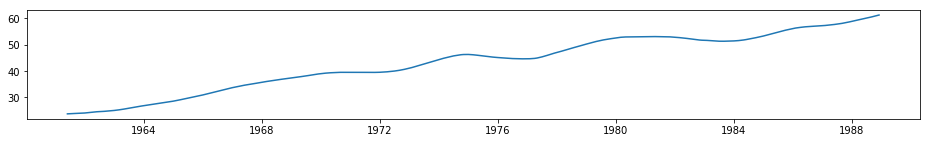

In [104]:
plt.figure(figsize=(16, 2))
MA = consumption.Value.rolling(window=30).mean()  # тренд

sns.lineplot(data=MA)
plt.show()

Тренд очевидно не стационарен

Сезонность

In [77]:
detrend_ = consumption.Value - MA

In [78]:
def sesonal_mean(x, period):  # наблюдения с шагом период 0, 0+period, 1+period
    return np.array([pd_nanmean(x[i::period], axis=0) for i in range(period)])


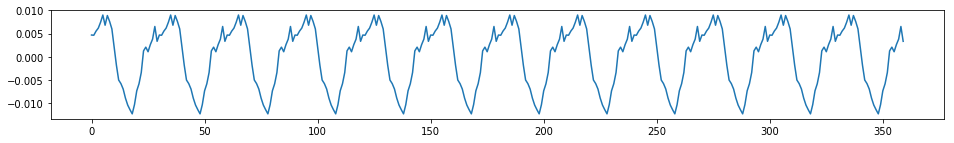

In [103]:
s_a = sesonal_mean(detrend_, 30)
s_a -= np.mean(s_a, axis=0)
nobs = detrend_.shape[0]

seasonal = np.tile(s_a.T, nobs // window + 1).T[:nobs]

plt.figure(figsize=(16, 2))
sns.lineplot(data=seasonal)
plt.show()

In [80]:
# seasonal.dropna(inplace=True)
fuller_res = adfuller(seasonal)
print('adf: ', fuller_res[0])
print('p-value: ', fuller_res[1])
print('Critical values: ', fuller_res[4])
if fuller_res[0] > fuller_res[4]['%5']:
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -15.187475329804805
p-value:  6.075994078350143e-28
Critical values:  {'1%': -3.4496162602188187, '%5': -2.870028369720798, '%10': -2.5712922615505627}
Единичных корней нет, ряд стационарен


Отсатки

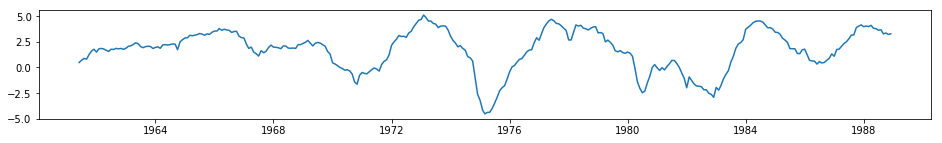

In [102]:
residuals = consumption.Value - MA - seasonal

plt.figure(figsize=(16, 2))

sns.lineplot(data=residuals)
plt.show()

In [82]:
residuals.dropna(inplace=True)
fuller_res = adfuller(residuals.values)
print('adf: ', fuller_res[0])
print('p-value: ', fuller_res[1])
print('Critical values: ', fuller_res[4])
if fuller_res[0] > fuller_res[4]['%5']:
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -4.737039258338927
p-value:  7.165571072365968e-05
Critical values:  {'1%': -3.450886958636161, '%5': -2.870586350823483, '%10': -2.5715897843576827}
Единичных корней нет, ряд стационарен


Мультипликативная модель

Тренд

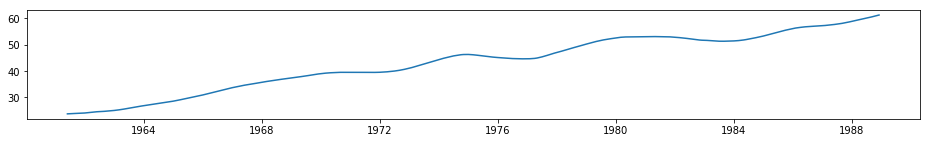

In [100]:
plt.figure(figsize=(16, 2))
MA = consumption.Value.rolling(window=30).mean()  # тренд

sns.lineplot(data=MA)
plt.show()

Сезонность

In [84]:
detrend_ = consumption.Value / MA

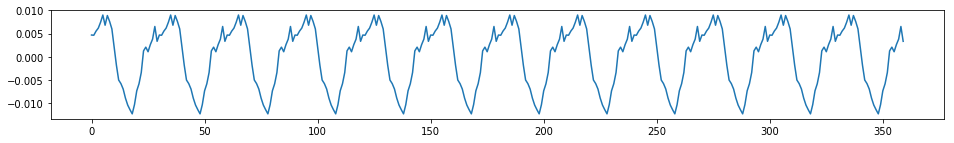

In [99]:
s_a = sesonal_mean(detrend_, 30)
s_a -= np.mean(s_a, axis=0)
nobs = detrend_.shape[0]

seasonal = np.tile(s_a.T, nobs // window + 1).T[:nobs]

plt.figure(figsize=(16, 2))
sns.lineplot(data=seasonal)
plt.show()

In [86]:
fuller_res = adfuller(seasonal)
print('adf: ', fuller_res[0])
print('p-value: ', fuller_res[1])
print('Critical values: ', fuller_res[4])
if fuller_res[0] > fuller_res[4]['%5']:
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -14.660578928755879
p-value:  3.386549851515222e-27
Critical values:  {'1%': -3.4496162602188187, '%5': -2.870028369720798, '%10': -2.5712922615505627}
Единичных корней нет, ряд стационарен


Отсатки

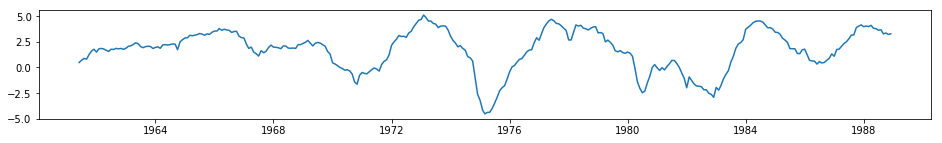

In [98]:
residuals = consumption.Value - MA - seasonal

plt.figure(figsize=(16, 2))
residuals.dropna(inplace=True)
sns.lineplot(data=residuals)

In [88]:
residuals.dropna(inplace=True)
fuller_res = adfuller(residuals.values)
print('adf: ', fuller_res[0])
print('p-value: ', fuller_res[1])
print('Critical values: ', fuller_res[4])
if fuller_res[0] > fuller_res[4]['%5']:
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -4.725148252782053
p-value:  7.546000276338102e-05
Critical values:  {'1%': -3.450886958636161, '%5': -2.870586350823483, '%10': -2.5715897843576827}
Единичных корней нет, ряд стационарен


#### 3.  Проверим является ли временной ряд интегрированным порядка k и если является, тогда применим к нему модель ARIMA, подобрав необходимые параметры с помощью функции автокорреляции и функции частичной автокорреляции. Отберем несколько моделей. Предскажем значения для тестовой выборки, а также визуализируем их и вычислим r2 score для каждой из моделей. Выберем лучшую модели с помощью информационного критерия Акаике. Проведем анализ получившихся результатов.

Как было рассчитано [ранее](#integrated_order_link) с помощью расширенного теста Дикки-Фуллера:
1. Удалением у каждой строки значения предыдущей строки __consumption.Value.diff(periods=i).dropna()__ и отбрасыванием первой строки, так как после метода __diff__ её значение становится __NaN__
2. Проведением теста Дикки-Фуллера на преобразованном временном ряде

исходынй ряд является нестационарным и интегрированным __порядка 1__


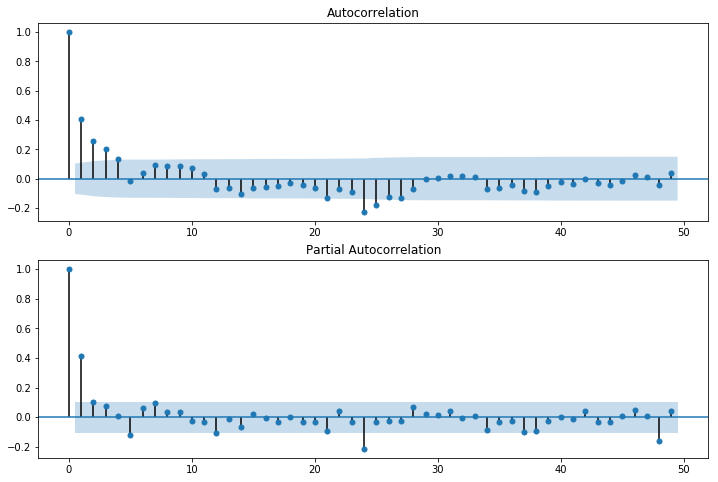

In [6]:
def _prepare_data_corr_plot(x, lags, zero):
    zero = bool(zero)
    irregular = False if zero else True
    if lags is None:
        # GH 4663 - use a sensible default value
        nobs = x.shape[0]
        lim = min(int(np.ceil(10 * np.log10(nobs))), nobs - 1)
        lags = np.arange(not zero, lim + 1)
    elif np.isscalar(lags):
        lags = np.arange(not zero, int(lags) + 1)  # +1 for zero lag
    else:
        irregular = True
        lags = np.asanyarray(lags).astype(np.int)
    nlags = lags.max(0)

    return lags, nlags, irregular


def _plot_corr(ax, title, acf_x, confint, lags, irregular, use_vlines,
               vlines_kwargs, **kwargs):
    if irregular:
        acf_x = acf_x[lags]
        if confint is not None:
            confint = confint[lags]

    if use_vlines:
        ax.vlines(lags, [0], acf_x, **vlines_kwargs)
        ax.axhline(**kwargs)

    kwargs.setdefault('marker', 'o')
    kwargs.setdefault('markersize', 5)
    if 'ls' not in kwargs:

        kwargs.setdefault('linestyle', 'None')
    ax.margins(.05)
    ax.plot(lags, acf_x, **kwargs)
    ax.set_title(title)

    if confint is not None:
        if lags[0] == 0:
            lags = lags[1:]
            confint = confint[1:]
            acf_x = acf_x[1:]
        lags = lags.astype(np.float)
        lags[0] -= 0.5
        lags[-1] += 0.5
        ax.fill_between(lags, confint[:, 0] - acf_x,
                        confint[:, 1] - acf_x, alpha=.25)


# Визуализация функции автокорреляции
def plot_acf(x, ax=None, lags=None, *, alpha=.05, use_vlines=True,
             unbiased=False, fft=False, missing='none',
             title='Autocorrelation', zero=True, vlines_kwargs=None):
    fig, ax = utils.create_mpl_ax(ax)

    lags, nlags, irregular = _prepare_data_corr_plot(x, lags, zero)
    vlines_kwargs = {} if vlines_kwargs is None else vlines_kwargs

    confint = None

    acf_x = acf(x, nlags=nlags, alpha=alpha, fft=fft, unbiased=unbiased,
                missing=missing)
    if alpha is not None:
        acf_x, confint = acf_x

    _plot_corr(ax, title, acf_x, confint, lags, irregular, use_vlines,
               vlines_kwargs)

    return fig


# наш исходный ряд преобразованный в стационарный
stationary = consumption.Value.diff(periods=1).dropna()
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(stationary.values.squeeze(), lags=49, ax=ax1)

# Визуализация функции частичной автокорреляции


def plot_pacf(x, ax=None, lags=None, alpha=.05, method='ywunbiased',
              use_vlines=True, title='Partial Autocorrelation', zero=True,
              vlines_kwargs=None):
    fig, ax = utils.create_mpl_ax(ax)
    vlines_kwargs = {} if vlines_kwargs is None else vlines_kwargs
    lags, nlags, irregular = _prepare_data_corr_plot(x, lags, zero)

    confint = None
    if alpha is None:
        acf_x = pacf(x, nlags=nlags, alpha=alpha, method=method)
    else:
        acf_x, confint = pacf(x, nlags=nlags, alpha=alpha, method=method)

    _plot_corr(ax, title, acf_x, confint, lags, irregular, use_vlines,
               vlines_kwargs)

    return fig


ax2 = fig.add_subplot(212)
fig = plot_pacf(stationary, lags=49, ax=ax2)

ACF экспоненциально затухает экспоненциально или синусоидальной волной, в зависимости от знаков параметров. При отрицательном значении параметра авторегрессии она экспоненциально затухает, меняя знак, при положительном - не меняя. PACF имеет выброс на лагах __1__ и __2__, для прочих лагов корреляции нет.

Еще один способ нахождения параметров __p__ и __q__, называемый "поиска по сетке" (или оптимизация гиперпараметров) для выбора модели, перебирающий различные комбинации параметров:

In [ ]:
p = q = range(0, 10)
d = 1
pq = list(itertools.product(p, q))
models = {}

warnings.filterwarnings("ignore")
pq
for param in pq:
    try:
        param = list(param)
        param.insert(1, 1)
        param = tuple(param)
        model = sm.tsa.ARIMA(consumption.Value, order=param).fit()
        models[param] = model.aic
    except BaseException:
        continue
models = sorted(models.items(), key=lambda x: x[1])

In [12]:
saved_models = models
models[:3] # топ 3 моделей отобранных по критерию Акаике

[((9, 1, 4), 241.22248892342589),
 ((8, 1, 6), 242.74185597043345),
 ((8, 1, 2), 243.39070584191631)]

Считаем тестовые данные:

In [8]:
test = pd.read_excel('testing.xlsx', index_col='Date')
test.head()

,Value
Date,
1989-01-01,64.6158
1989-02-01,64.3268
1989-03-01,64.4548
1989-04-01,64.5270
1989-05-01,64.0662


In [13]:
def plot_predicted_values_of_model(order):
    model = sm.tsa.ARIMA(
        consumption.Value.squeeze(),
        order=order,
        freq='MS').fit()
    y_r = model.predict(
        start=consumption.shape[0],
        end=consumption.shape[0] +
        test.shape[0] -
        1,
        typ='levels')
    plt.figure(figsize=(15, 8))
    plt.plot(consumption.Value, label='Train', color='pink')
    plt.plot(test.Value, label='Test')
    plt.plot(y_r, label='ARIMA')
    plt.legend(loc='best')
    print('score: {}'.format(r2_score(test.Value, y_r)))
    print('aic: {}'.format(model.aic))
    plt.show()

score: -4.019195540106127
aic: 241.22248892342589


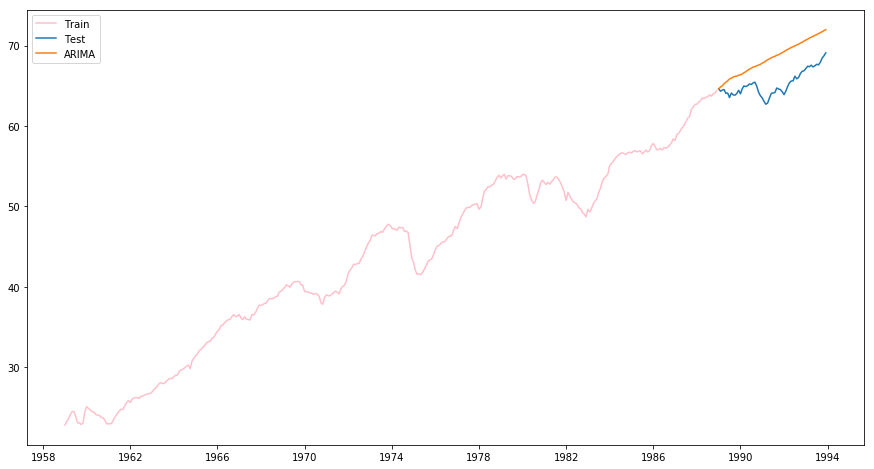

score: -3.132179368375815
aic: 242.74185597043345


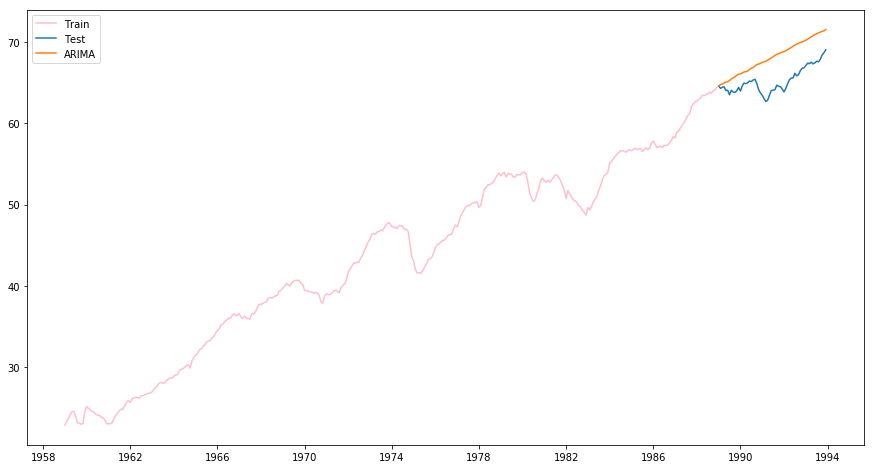

score: -3.7757909402805554
aic: 243.39070584191631


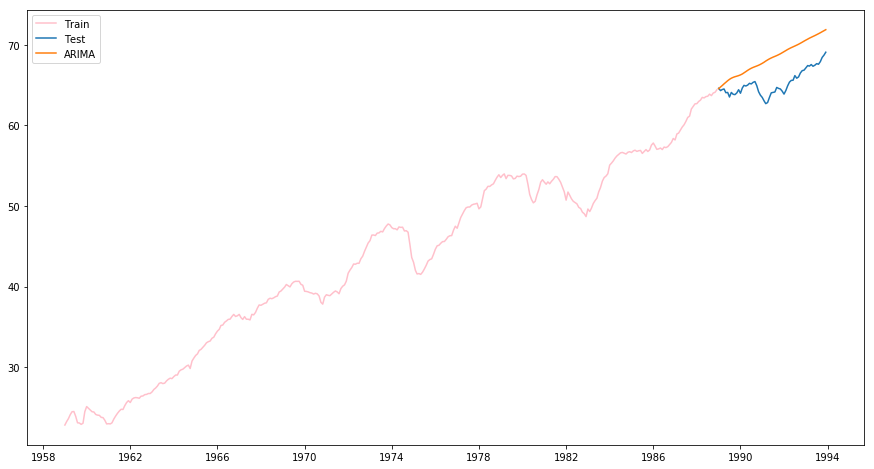

In [11]:
# Визуализируем топ 3 модели и посчитаем их score
for param in saved_models[:3]:
    plot_predicted_values_of_model(param[0])

ACF экспоненциально затухает, начиная с первого лага, причем затухание может носить монотонный или колебательный характер. PACF затухает экспоненциально, монотонно или колебательно.